## About this API process

100 articles related to the brain tumor microenvironment (TME) will be gathered using the Semantic Scholar API. This API allows quick retreival of metadata for scientific publications.

The goal of using this API is to analyze abstracts from recent publications on the brain TME to gain insights into recent developments and trends in the fields.

Datasets can also be downloaded from publications using the Semantic Scholar API. So, if articles of interest are identified from the original GET, specific data will be pulled and analyzed further.

In [3]:
## import necessary packages

from requests import Session
import json
import re  #regular expressions
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer  #for text vectorization
import matplotlib.pyplot as plt 

In [6]:
# define the search query and filters
query = "brain tumor microenvironment"
fields = "paperId,title,year,authors,fieldsOfStudy,abstract,url" #choose fields to get
limit =100  # get 100 papers in one request
publication_types = "JournalArticle,Review,ClinicalTrial"  # filter by publication types
fields_of_study = "Medicine,Public Health,Chemistry,Biology"  # filter by fields of study
year = "2020-2023"  # papers published between 2020 and 2023

#initialize session
http = Session()

#use requests library to build url
request = http.get( 
    "https://api.semanticscholar.org/graph/v1/paper/search",
    params={
        'query': query,
        'fields': fields,
        'limit': limit,
        'publicationTypes': publication_types,
        'fieldsOfStudy': fields_of_study,
        'year': year
    }
)

# print url, can run in web brower to check function
print(request.url)

# stop if there's an error
request.raise_for_status() 

#pull data, save as json data
jsontxt = request.json()

# create a new csv file to save abstracts (and other metadata)
filename="tme_abstracts.csv"

# open file, write column names into first row, close file (then locate file on computer)
my_file=open(filename,"w")
write_this="paper id,year,title,abstract,url\n"
my_file.write(write_this)
my_file.close()

# open the file for append
my_file=open(filename, "a")

## iterate through json text, cleaning text in desired categories and assigning variable names:
for items in jsontxt["data"]:
    id=items["paperId"]
    year=items["year"]
    url=items["url"]
    
    # clean title
    title=items["title"]
    title=re.sub(r'[^a-zA-Z]', " ", title, flags=re.VERBOSE)
    title=' '.join(title.split())
    title=re.sub("\n|\r", "", title)

    # clean abstract
    abstract=items["abstract"]
    if abstract != None:
        abstract=re.sub(r'[^a-zA-Z]', " ", abstract, flags=re.VERBOSE)
        abstract=abstract.replace(',', '')
        abstract=' '.join(abstract.split())
        abstract=re.sub("\n|\r", "", abstract)

   # write cleaned items into file 
    write_this=str(id)+","+ str(year)+","+ str(title)+","+ str(abstract) + "," + str(url) + "\n"
    my_file.write(write_this)
    
# close file (and check that local csv file was updated)
my_file.close()

https://api.semanticscholar.org/graph/v1/paper/search?query=brain+tumor+microenvironment&fields=paperId%2Ctitle%2Cyear%2Cauthors%2CfieldsOfStudy%2Cabstract%2Curl&limit=100&publicationTypes=JournalArticle%2CReview%2CClinicalTrial&fieldsOfStudy=Medicine%2CPublic+Health%2CChemistry%2CBiology&year=2020-2023


In [11]:
# now tokenize and vectorize abstracts
# read to csv file into dataframe
abstract_df=pd.read_csv(filename, on_bad_lines= 'skip')
#print(abstract_df.head())

 # drop rows with NA for abstract   
abstract_df = abstract_df.dropna()

# create the list of abstracts
abstract_list=[]
for next in abstract_df["abstract"]:
     abstract_list.append(next)

# vectorize using CountVectorizer, filter stop words
my_count_v=CountVectorizer(
     input="content", 
     lowercase=True, 
     stop_words = "english"
     )

# create a sparse matrix 
vectorized_abstract_df = my_count_v.fit_transform(abstract_list) 
#print(type(vectorized_abstract_df))

#vocab is a vocabulary list
# change to a list
vocab = my_count_v.get_feature_names_out()  
#print(list(vocab)[10:20])

# convert to a regular array
vectorized_abstract_df = vectorized_abstract_df.toarray()  
#print(type(vectorized_abstract_df))

#create df
column_names=my_count_v.get_feature_names_out()
vectorized_abstract_df=pd.DataFrame(vectorized_abstract_df,columns=column_names)

#check df
print(vectorized_abstract_df.head())

#convert and save as csv
vectorized_abstract_df.to_csv("tme_vectorized_abstracts.csv", index=False)

   aberrant  aberrations  ability  able  abnormal  abnormalities  abrogated  \
0         0            0        0     0         0              0          0   
1         0            0        0     0         0              0          0   
2         0            0        0     0         0              0          0   
3         0            0        0     0         0              0          0   
4         0            0        0     0         0              0          0   

   absence  abstract  abt  ...  xav  xenograft  xenografts  xiangya  yb  year  \
0        0         0    0  ...    0          0           0        0   0     0   
1        0         1    0  ...    0          0           0        0   0     0   
2        1         0    0  ...    0          0           0        0   0     0   
3        0         1    1  ...    0          0           0        0   0     0   
4        0         0    0  ...    0          0           0        0   0     0   

   years  yielded  zone  zones  
0    

tumor               306
cells               228
brain               227
cell                143
immune              139
microenvironment    132
gbm                 112
glioma               94
cancer               88
tme                  84
expression           70
patients             68
treatment            62
tumors               62
associated           51
cd                   50
metastases           48
glioblastoma         48
therapeutic          47
primary              46
high                 45
bm                   44
metastasis           43
study                42
immunotherapy        40
lung                 39
related              38
growth               38
therapy              35
macrophages          35
dtype: int64


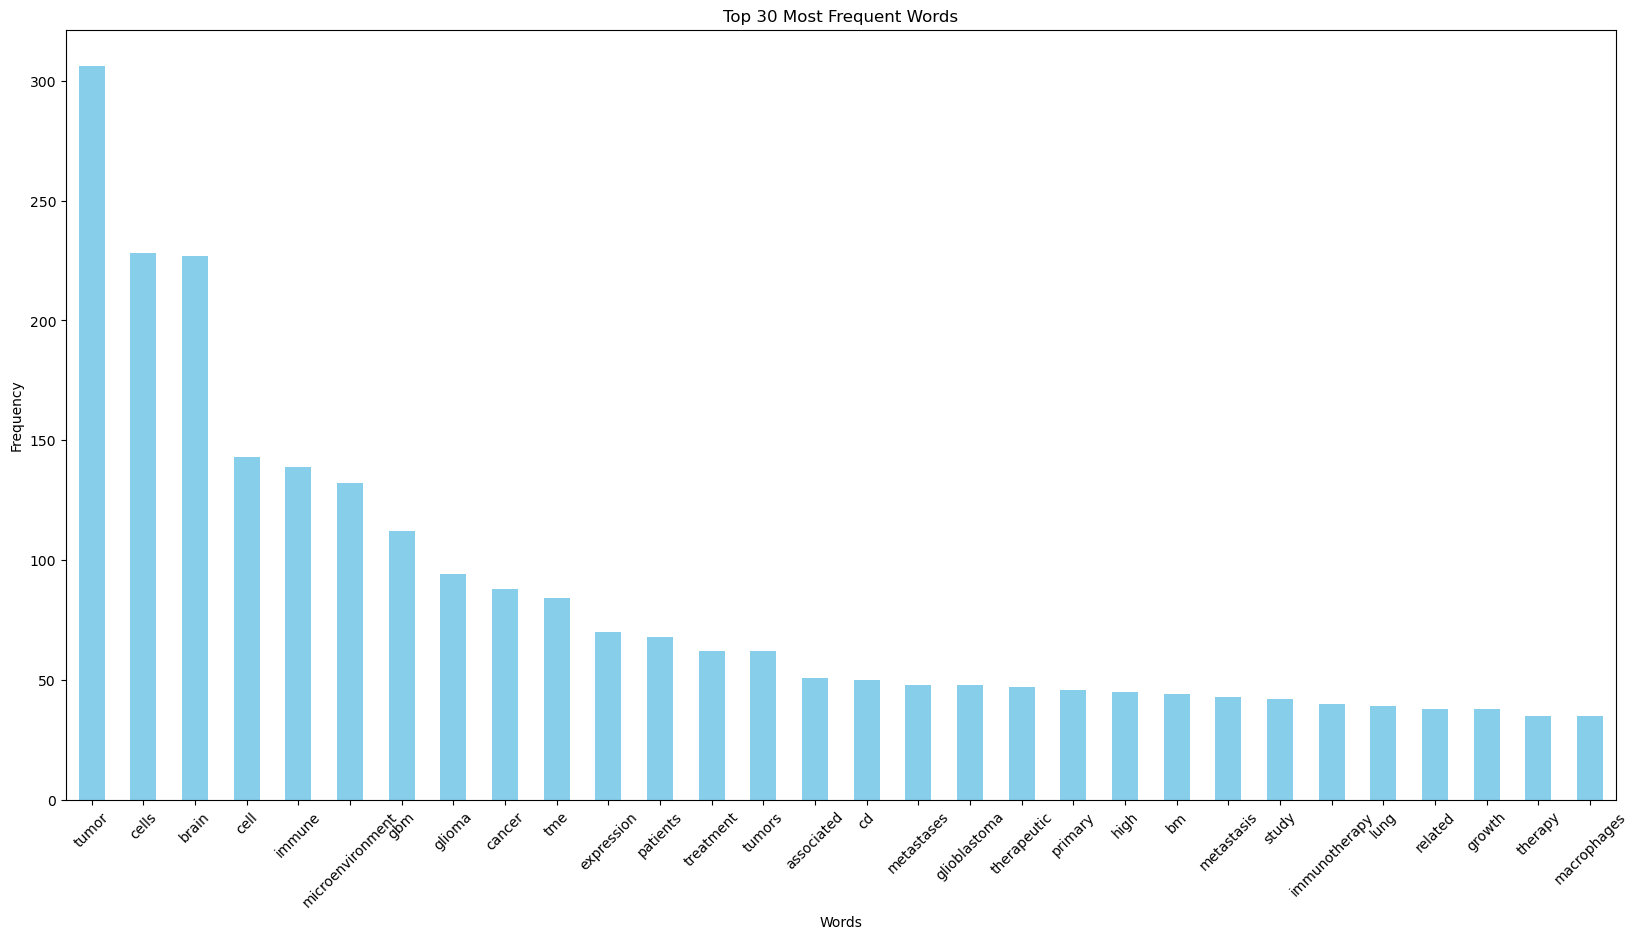

In [13]:
# initialze EDA visualization for most common words

#sum column frequencies and sort by most common
word_frequencies = vectorized_abstract_df.sum(axis=0)
sorted_word_frequencies = word_frequencies.sort_values(ascending=False)

# select the top 30 most frequent words
top_30_words = sorted_word_frequencies.head(30)

print(top_30_words)

# plot the top 30 most frequent words
plt.figure(figsize=(20, 10))
top_30_words.plot(kind='bar', color='skyblue')

# add labels and title
plt.title('Top 30 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

# 4otate x-axis labels for better readability
plt.xticks(rotation=45)

# show plot
plt.show()